# Fig 4: Activation and PPIs/Dimerization

considering effector domains to just be from the functional studies (no pfam domains). results do not change that much, and makes the code/explanation cleaner to focus on effector domains imo.

In [1]:
import numpy as np
import matplotlib as mpl
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns
import sys

from statannotations.Annotator import Annotator

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import (mimic_r_boxplot,
                      violinplot_reflected,
                      y2h_ppi_per_tf_gene_plot,
                      y1h_pdi_per_tf_gene_plot,
                      m1h_activation_per_tf_gene_plot)

from data_loading import (load_y2h_isoform_data, 
    load_m1h_activation_data, 
    load_ppi_partner_categories, 
    load_annotated_TFiso1_collection,
    load_human_tf_db,
    load_y1h_pdi_data,
    load_tf_families,
    DIMERIZING_TF_FAMILIES,
   load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones)

from isoform_pairwise_metrics import load_ref_vs_alt_isoforms_table, _add_PPI_columns

In [2]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## 1. load TFs, assay data (Y2H, M1H), Pfam domains, and PPI partner categories/cofactors

In [5]:
tfs = load_annotated_TFiso1_collection()
pairs = load_ref_vs_alt_isoforms_table()

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
pairs = pairs[pairs["clone_acc_alt"] != "RORC|1/6|05F11"]

pairs['ref_iso'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['alt_iso'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['f_disorder_difference'] = pairs.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)

reading from cache


In [6]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
cats = load_ppi_partner_categories()

reading from cache
reading from cache


In [7]:
df = pd.read_excel('../../data/external/Geiger-et-al_MCP_2012_Supplementary-Table-2.xlsx',
                   skiprows=1)
hek_avrg = df[['iBAQ HEK293_1', 'iBAQ HEK293_2', 'iBAQ HEK293_3']].mean(axis=1)
print((hek_avrg > 0).sum(), 'proteins expressed in HEK293 proteome')
hek_expressed_genes = set(df.loc[(hek_avrg > 0) & df['Gene Names'].notnull(),
       'Gene Names'].str.split(';').explode().values)
all_partners = set(y2h['db_gene_symbol'].unique())
print('of {} PPI partners, {} are expressed in HEK293 cells'.format(len(all_partners), 
      len(all_partners.intersection(hek_expressed_genes))))

8543 proteins expressed in HEK293 proteome
of 500 PPI partners, 252 are expressed in HEK293 cells


In [8]:
# now add Pfam AD/RDs
pfam = pd.read_csv('../../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])

In [9]:
cof = pd.read_csv('../../data/external/AnimalTFDB3_Homo_sapiens_TF_cofactors.txt',
                 sep='\t')
if cof['Symbol'].duplicated().any():
    raise UserWarning('unexpected duplicates')

## 2. categorize effector domain changes between alt/ref iso

In [10]:
dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])

# add activation or repression annotation from effector domain studies
effector_domain_type = {}
for tf in tfs.values():
    for d in tf.cloned_reference_isoform.aa_seq_features:
        if d.category == 'effector_domain':
            effector_domain_type[d.accession] = d.name
dom['type'] = dom['accession'].map(effector_domain_type)

In [11]:
# add activation or repression annotation from Pfam domains directly
pfam_ad = pfam[(pfam['name'].str.contains("transcription activation")) | 
               (pfam['name'].str.contains("transactivation")) |
               (pfam['short_name'].str.contains("TAD"))].copy()
pfam_ad["type"] = "AD"

# RD
pfam_rd = pfam[(pfam['short_name'].str.contains("NRIP1_repr")) | 
               (pfam['name'].str.contains("KRAB"))].copy()
pfam_rd["type"] = "RD"
pfam_effs = pd.concat([pfam_ad, pfam_rd])

def get_pfam_type(row):
    if not pd.isnull(row['type']):
        return row['type']
    else:
        pfam_sub = pfam_effs[pfam_effs['pfam_accession'] == row['accession']]
        if len(pfam_sub) > 0:
            return pfam_sub['type'].iloc[0]
        else:
            return np.nan
dom["type_incl_pfam"] = dom.apply(get_pfam_type, axis=1)

In [12]:
# # considering Pfam and Effector domains
# def fraction_of_effector_domains_removed(row, effector_type):
#     ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
#                   & (dom['type_incl_pfam'] == effector_type), :]
#     if ds.shape[0] == 0:
#         return np.nan
#     return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


# def insertion_in_effector_domains(row, effector_type):
#     ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
#                   & (dom['type_incl_pfam'] == effector_type), :]
#     if ds.shape[0] == 0:
#         return np.nan
#     return ds['insertion'].sum()

# def domain_length(row, effector_type):
#     ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
#                   & (dom['type_incl_pfam'] == effector_type), :]
#     if ds.shape[0] == 0:
#         return np.nan
#     return ds['length'].sum()


# for effector_type in ['AD', 'RD', 'Bif']:
#     pairs['fraction_of_{}_domains_removed_incl_pfam'.format(effector_type)] = pairs.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
#     pairs['insertion_in_{}_domains_incl_pfam'.format(effector_type)] = pairs.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
#     pairs['length_of_{}_domains_incl_pfam'.format(effector_type)] = pairs.apply(domain_length, effector_type=effector_type, axis=1)

In [13]:
# considering Pfam and Effector domains
def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()

def domain_length(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['length'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    pairs['fraction_of_{}_domains_removed'.format(effector_type)] = pairs.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    pairs['insertion_in_{}_domains'.format(effector_type)] = pairs.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)
    pairs['length_of_{}_domains'.format(effector_type)] = pairs.apply(domain_length, effector_type=effector_type, axis=1)

## 3. plot number of annotated domains (of various types) across isoforms

Text(0.5, 0, 'Effector domains in reference isoform')

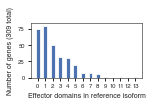

In [14]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain':
            c += 1
    return c

n_effector = [count_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')

Text(0.5, 1.0, 'Soto et al. data')

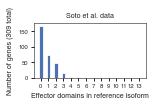

In [15]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Soto_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_soto = [count_Soto_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector_soto,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Soto et al. data')

Text(0.5, 1.0, 'Data from Bintu lab papers')

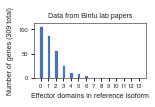

In [16]:
# plot of number of activation domains per ref iso
# fraction of sequnce within effector domains
def count_Bintu_effector_domains(gene):
    iso = gene.cloned_reference_isoform
    c = 0
    for d in iso.aa_seq_features:
        if d.category == 'effector_domain' and not d.accession.startswith('Soto'):
            c += 1
    return c

n_effector_bintu = [count_Bintu_effector_domains(tf) for tf in tfs.values()]

fig, ax = plt.subplots(1, 1, figsize=(2, 1))
ax.hist(n_effector_bintu,
        range=(-0.25, max(n_effector) + 0.25),
          bins=(max(n_effector) * 2 + 1))
ax.set_xticks(range(max(n_effector) + 1))
ax.set_ylabel('Number of genes ({} total)'.format(len(tfs)))
ax.set_xlabel('Effector domains in reference isoform')
ax.set_title('Data from Bintu lab papers')

In [17]:
counter = {'Soto': {'AD': 0, 'RD': 0, 'Bif': 0},
           'Tycko': {'AD': 0, 'RD': 0},
           'DelRosso': {'AD': 0, 'RD': 0}}
for tf in tfs.values():
    has_effector = False
    for domain in tf.cloned_reference_isoform.aa_seq_features:
        if domain.category == 'effector_domain':
            counter[domain.accession.split('_')[0]][domain.name] += 1
counter

{'Soto': {'AD': 156, 'RD': 80, 'Bif': 4},
 'Tycko': {'AD': 4, 'RD': 48},
 'DelRosso': {'AD': 37, 'RD': 345}}

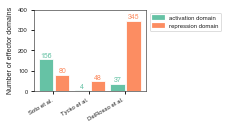

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
ax.bar(x=[0.1, 1.0, 2.1, 3.0, 4.1, 5.0],
       height=[counter[x][y] for x in counter.keys() for y in ['AD', 'RD']],
       color=[sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]] * 3)
ax.set_xticks([0.5, 2.5, 4.5])
ax.set_xticklabels(['Soto et al.', 'Tycko et al.', 'DelRosso et al.'], rotation=30, ha="right", va="top")
ax.set_ylabel('Number of effector domains')

# annotate
rects = ax.patches
labels = [counter[x][y] for x in counter.keys() for y in ['AD', 'RD']]
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]] * 3
for rect, label, color in zip(rects, labels, colors):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom", color=color)

colors = {"activation domain": sns.color_palette("Set2")[0], 
          "repression domain": sns.color_palette("Set2")[1]}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc=2, bbox_to_anchor=(1.01, 1))

plt.ylim((0, 400))

fig.savefig("../../figures/fig4/annotated_effector_domain_count.pdf", dpi="figure", bbox_inches="tight")

## 4. summary plot looking at presence of activ/repr domains and activity

In [19]:
# define activity above baseline as >= 1 (absolute value)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
m1h['gte_above'] = (m1h['mean'] >= 1)
m1h['gte_below'] = (m1h['mean'] <= -1)
m1h.head()

,gene_symbol,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3,mean,gte_2_fold,gte_above,gte_below
360,AEBP2,AEBP2|2/3|05F03,0.241019,0.189211,0.473661,0.301297,False,False,False
359,AEBP2,AEBP2|3/3|05E07,-0.276303,-0.305477,-0.121186,-0.234322,False,False,False
0,ARNT2,ARNT2|1/6|08C12,4.498733,4.501519,4.297244,4.432498,True,True,False
1,ARNT2,ARNT2|2/6|09E01,2.407721,2.407411,2.197963,2.337698,True,True,False
3,ARNTL2,ARNTL2|2/5|12C06,0.398027,0.391809,0.299461,0.363099,False,False,False


In [20]:
ads = []
rds = []
bifs = []

for i, row in m1h.iterrows():
    gene = row.gene_symbol
    iso = row.clone_acc
    try:
        tf_iso = tfs[gene][iso]
    except KeyError:
        print("missing tf %s or iso %s" % (gene, iso))
        ads.append(np.nan)
        rds.append(np.nan)
        bifs.append(np.nan)
        continue
    
    has_ad = False
    has_rd = False
    has_bif = False
    for domain in tf_iso.aa_seq_features:
        if domain.category == 'effector_domain':
            if domain.name == "AD":
                has_ad = True
            if domain.name == "RD":
                has_rd = True
            if domain.name == "Bif":
                has_bif = True
    
    ads.append(has_ad)
    rds.append(has_rd)
    bifs.append(has_bif)

missing tf FOXD4L3 or iso FOXD4L3|1/2|04G01
missing tf NANOG or iso NANOG|1/2|01C08
missing tf NANOG or iso NANOG|2/2|01H08
missing tf PCGF6 or iso PCGF6|1/2|11A10
missing tf PCGF6 or iso PCGF6|2/2|11B07


In [21]:
m1h['has_ad'] = ads
m1h['has_rd'] = rds
m1h['has_bif'] = bifs

# filter out the above isos that got removed from clone collection post-hoc
m1h = m1h[~pd.isnull(m1h['has_ad'])]
len(m1h)

617

In [22]:
len(m1h.gene_symbol.unique())

261

In [23]:
def cat_dom(row):
    if row.has_ad == True and row.has_rd == False and row.has_bif == False:
        return "activation domain"
    elif row.has_ad == False and row.has_rd == True and row.has_bif == False:
        return "repression domain"
    elif row.has_ad == False and row.has_rd == False and row.has_bif == True:
        return "bifunctional domain"
    elif row.has_ad == False and row.has_rd == False and row.has_bif == False:
        return "no annotated domains"
    else:
        return "combination of domains"

m1h["cat_dom"] = m1h.apply(cat_dom, axis=1)
m1h.cat_dom.value_counts()

no annotated domains      214
repression domain         202
combination of domains    146
activation domain          53
bifunctional domain         2
Name: cat_dom, dtype: int64

In [24]:
def cat_gte(row):
    if row.gte_above:
        return "above baseline"
    elif row.gte_below:
        return "below baseline"
    else:
        return "NA"
    
m1h["cat_gte"] = m1h.apply(cat_gte, axis=1)
m1h.cat_gte.value_counts()

above baseline    314
NA                254
below baseline     49
Name: cat_gte, dtype: int64

In [25]:
m1h_filt = m1h[(m1h["cat_gte"] != "NA") & (m1h["cat_dom"].isin(["activation domain", "repression domain"]))]
m1h_filt = pd.pivot_table(m1h_filt, index="cat_dom", columns="cat_gte", values='clone_acc', aggfunc='count')
print(m1h_filt.sum())
m1h_filt = m1h_filt/m1h_filt.sum()
m1h_filt

cat_gte
above baseline    118
below baseline     24
dtype: int64


cat_gte,above baseline,below baseline
cat_dom,,
activation domain,0.313559,0.041667
repression domain,0.686441,0.958333


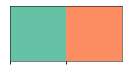

In [26]:
palette = {"activation domain": sns.color_palette("Set2")[0],
           "repression domain": sns.color_palette("Set2")[1]}
sns.palplot(palette.values())

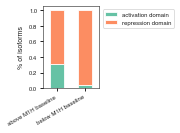

In [27]:
ax = m1h_filt.T.plot.bar(stacked=True, color=palette.values(), figsize=(1, 1.5))

ax.set_ylabel("% of isoforms")
ax.set_xlabel("")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1))
ax.set_xticklabels(["above M1H baseline", "below M1H baseline"], ha="right", va="top", rotation=30)

plt.savefig('../../figures/fig4/m1h_baseline_doms.pdf',
            bbox_inches='tight')

## 5. summary plot looking at gain/loss of domains and activity

In [28]:
pairs['m1h_gte_2_fold_at_least_one_iso_per_gene'] = pairs['gene_symbol'].map(m1h.groupby('gene_symbol')
                                                                             ['gte_2_fold']
                                                                             .any())
pairs['abs_activation_fold_change_log2'] = pairs['activation_fold_change_log2'].abs()

In [29]:
# # create a color map of domain length
# # sum up lengths of all domains (plot only includes examples w 1 type of domain)
# pairs['tot_dom_length_incl_pfam'] = pairs[['length_of_AD_domains_incl_pfam', 'length_of_RD_domains_incl_pfam', 'length_of_Bif_domains_incl_pfam']].sum(axis=1)
# t_dom_length_incl_pfam = pairs.loc[:,'tot_dom_length_incl_pfam'].values
# t_dom_length_incl_pfam = t_dom_length_incl_pfam[t_dom_length_incl_pfam > 0]

# # using min and max makes colors too hard too read - cut off
# cmap = sns.color_palette("flare", as_cmap=True)
# norm = plt.Normalize(25, 250)
# palette_dom_length_incl_pfam = {value: cmap(norm(value)) for value in t_dom_length_incl_pfam}

# def re_color(row, palette):
#     if row['tot_dom_length_incl_pfam'] == 0:
#         color = sns.color_palette("flare")[0]
#     else:
#         color = palette[row['tot_dom_length_incl_pfam']]
#     return color

# pairs["color_dom_length_incl_pfam"] = pairs.apply(re_color, axis=1, palette=palette_dom_length_incl_pfam)

In [30]:
# create a color map of domain length
# sum up lengths of all domains (plot only includes examples w 1 type of domain)
pairs['tot_dom_length'] = pairs[['length_of_AD_domains', 'length_of_RD_domains', 'length_of_Bif_domains']].sum(axis=1)
t_dom_length = pairs.loc[:,'tot_dom_length'].values
t_dom_length = t_dom_length[t_dom_length > 0]

# using min and max makes colors too hard too read - cut off
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(25, 250)
palette_dom_length = {value: cmap(norm(value)) for value in t_dom_length}

def re_color(row, palette):
    if row['tot_dom_length'] == 0:
        color = sns.color_palette("flare")[0]
    else:
        color = palette[row['tot_dom_length']]
    return color

pairs["color_dom_length"] = pairs.apply(re_color, axis=1, palette=palette_dom_length)

In [31]:
df = pairs.copy()
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]

In [32]:
print("# ref/alt isoform pairs with M1H data/signal: %s" % len(df))

# ref/alt isoform pairs with M1H data/signal: 254


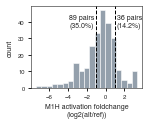

In [33]:
fig = plt.figure(figsize=(2, 1.5))
ax = sns.histplot(data=df, x="activation_fold_change_log2", color="slategrey")
ax.set_xlabel("M1H activation foldchange\n(log2(alt/ref))")
ax.set_ylabel("count")

ax.axvline(x=-1, linestyle="dashed", color="black", linewidth=1)
ax.axvline(x=1, linestyle="dashed", color="black", linewidth=1)

# annotate
n_less_neg1 = len(df[df["activation_fold_change_log2"] <= -1])
n_greater_1 = len(df[df["activation_fold_change_log2"] >= 1])

ax.text(-1.2, 40, "%s pairs\n(%s%%)" % (n_less_neg1, np.round(n_less_neg1/len(df)*100, 1)), ha="right", va="center")
ax.text(1.2, 40, "%s pairs\n(%s%%)" % (n_greater_1, np.round(n_greater_1/len(df)*100, 1)), ha="left", va="center")

fig.savefig("../../figures/fig4/m1h_alt_ref_dist.pdf", dpi="figure", bbox_inches="tight")

In [34]:
# palette = palette_dom_length_incl_pfam
# hue = 'tot_dom_length_incl_pfam'
# color = 'color_dom_length_incl_pfam'
# t = t_dom_length_incl_pfam

# gs_kw = dict(width_ratios=[0.4, 0.4, 0.5, 1.1, 1.1, 1.75, 0.85])

# fig, axs = plt.subplots(1, 7, sharey=True, gridspec_kw=gs_kw)
# fig.set_size_inches(w=8.2, h=2)

# point_size = 6


# tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) 
#                         & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
#                            (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
#                         & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
#                            (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
# axs[0].set_title('activation\ndomain')
# sns.swarmplot(data=tot_loss_activ,
#               y='activation_fold_change_log2', 
#               x='fraction_of_AD_domains_removed_incl_pfam',
#               size=point_size,
#             clip_on=False,
#               ax=axs[0],
#               palette=palette,
#               hue=hue,
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[0].set_xticks([])
# axs[0].set_xlabel('')
# axs[0].get_legend().remove()

# tbx5_y = df.loc[(df["clone_acc_alt"] == "TBX5|3/3|08H01"), 'activation_fold_change_log2'].values[0]
# for point in axs[0].collections:
#     for x, y in point.get_offsets():
#         if np.isclose(tbx5_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[0].annotate("TBX5-3", xy=(x, y), xytext=(0, -10), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
#                                               color='black'), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed_incl_pfam'] == 1)
#                           & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
#                              (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
#                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
#                              (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)), :]
# axs[1].set_title('repression\ndomain')
# sns.swarmplot(data=tot_loss_repr,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed_incl_pfam',
#               size=point_size,
#             clip_on=False,
#               ax=axs[1],
#               palette=palette,
#               hue=hue,
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[1].set_xticks([])
# axs[1].set_xlabel('')
# axs[1].get_legend().remove()

# dlx1_y = df.loc[(df["clone_acc_alt"] == "DLX1|2/2|07E09"), 'activation_fold_change_log2'].values[0]
# for point in axs[1].collections:
#     for x, y in point.get_offsets():
#         if np.isclose(dlx1_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[1].annotate("DLX1-2", xy=(x, y), xytext=(0, 10), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
#                                               color='black'), 
#                             ha="center", va="bottom", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


# tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed_incl_pfam'] == 1) &
#                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains')
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed_incl_pfam',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue=hue,
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# # now partial loss
# axs[3].set_title('activation\ndomain')
# partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
#               & (df['fraction_of_AD_domains_removed_incl_pfam'] > 0) 
#                 & (df['fraction_of_AD_domains_removed_incl_pfam'] < 1)
#                         & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | 
#                            (df['fraction_of_RD_domains_removed_incl_pfam'] == 0))
#                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
#                              (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]
# axs[3].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed_incl_pfam'].values,
#                partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
#            alpha=1,
#            s=point_size**2,
#             c=partial_loss_activ.loc[:, color].values,
#                linewidth=1,
#                edgecolor="black",
#            clip_on=False)
# axs[3].set_xlabel('')
# axs[3].set_xlim(1, 0)
# axs[3].set_xticks([0.99, 0.5, 0.01])
# axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


# axs[4].set_title('repression\ndomain')
# partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
#                 & (df['fraction_of_RD_domains_removed_incl_pfam'] > 0)
#                   &  (df['fraction_of_RD_domains_removed_incl_pfam'] < 1)
#                           & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | 
#                              (df['fraction_of_AD_domains_removed_incl_pfam'] == 0))
#                           & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | 
#                              (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))), :]

# axs[4].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed_incl_pfam'].values,
#                partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
#            alpha=1,
#            s=point_size**2,
#             c=partial_loss_repr.loc[:, color].values,
#                linewidth=1,
#                edgecolor="black",
#            clip_on=False)
# axs[4].set_xlabel('')
# axs[4].set_xlim(1, 0)
# axs[4].set_xticks([0.99, 0.5, 0.01])
# axs[4].set_xticklabels([f'{x:.0%}' for x in axs[4].get_xticks()])


# all_retained = df.loc[((df['fraction_of_AD_domains_removed_incl_pfam'] == 0) |
#                           (df['fraction_of_RD_domains_removed_incl_pfam'] == 0) |
#                           (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0))
#                           & (df['fraction_of_AD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_AD_domains_removed_incl_pfam'] == 0)) 
#                            & (df['fraction_of_RD_domains_removed_incl_pfam'].isnull() | (df['fraction_of_RD_domains_removed_incl_pfam'] == 0)) 
#                            & (df['fraction_of_Bif_domains_removed_incl_pfam'].isnull() | (df['fraction_of_Bif_domains_removed_incl_pfam'] == 0)) 
#                            ,
#                            :]
# axs[5].set_title('All effector domains\nin alt. iso.')
# sns.swarmplot(data=all_retained,
#               y='activation_fold_change_log2', 
#               x='m1h_gte_2_fold_at_least_one_iso_per_gene',
#               size=point_size,
#             clip_on=False,
#               ax=axs[5],
#                linewidth=1,
#                edgecolor="black",
#               alpha=1,
#               hue=hue,
#               palette=palette)
# axs[5].set_xticks([])
# axs[5].set_xlabel('')
# axs[5].get_legend().remove()

# # annotate pbx1 and rfx3
# pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
# rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
# rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
# creb5_y = df.loc[(df["clone_acc_alt"] == "CREB5|2/3|08A12"), 'activation_fold_change_log2'].values[0]
# for point in axs[5].collections:
#     for x, y in point.get_offsets():
#         if np.isclose(pbx1_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[5].annotate("PBX1-2", xy=(x, y), xytext=(-10, -10), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
#                                               color='black'), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#         if np.isclose(rfx3_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[5].annotate("RFX3-3", xy=(x, y), xytext=(-8, -7), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.2",
#                                               color='black'), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#         if np.isclose(rfx4_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[5].annotate("RFX3-4", xy=(x, y), xytext=(8, -8), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
#                                               color='black'), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#         if np.isclose(creb5_y, y):
#             print("found: %s, %s" % (x, y))
#             axs[5].annotate("CREB5-2", xy=(x, y), xytext=(-23, -8), textcoords='offset points',
#                             arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
#                                               color='black'), 
#                             ha="center", va="top", fontsize=7,
#                             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# # missing stuff
# incl = pd.concat([tot_loss_activ, 
#                   tot_loss_repr, 
#                   tot_loss_both, 
#                   partial_loss_activ, 
#                   partial_loss_repr, 
#                   all_retained])

# no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed_incl_pfam"])) &
#                   (pd.isnull(df["fraction_of_RD_domains_removed_incl_pfam"])) & 
#                   (pd.isnull(df["fraction_of_Bif_domains_removed_incl_pfam"]))]
# axs[6].set_title('No annotated\neffector domains')
# sns.swarmplot(data=no_annot,
#               y='activation_fold_change_log2', 
#               x='m1h_gte_2_fold_at_least_one_iso_per_gene',
#               size=point_size,
#             clip_on=False,
#               ax=axs[6],
#               linewidth=1,
#                edgecolor="black",
#               alpha=1,
#               color=sns.color_palette("flare")[0])
# axs[6].set_xticks([])
# axs[6].set_xlabel('')


# # add colorbar
# # mirror figure
# fig2, axs2 = plt.subplots(1, 7, sharey=True, gridspec_kw=gs_kw)
# fig2.set_size_inches(w=8.2, h=2)
# map1 = axs2[6].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
# cbar = fig.colorbar(map1, ax=axs[6], aspect=30, pad=0.2)
# cbar.set_ticks([25, 75, 150, 250])
# cbar.set_ticklabels(["<=25", "75", "150", ">=250"])
# cbar.set_label("# AA in annotated domain", labelpad=0)


# for ax in axs:
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.set_ylim(-7.5, 7.5)
#     ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed', zorder=1)
# for ax in axs[1:]:
#     ax.spines['left'].set_visible(False)
#     ax.yaxis.set_tick_params(which='both', length=0)
#     ax.set_ylabel("")
# axs[0].set_ylabel("log2(activation fold change)")
# fig.savefig('../../figures/fig4/activation_vs_domain_removal_incl_pfam_colored_by_dom_length.pdf', bbox_inches='tight')

found: 4.440892098500626e-16, -3.1682185672413987
found: 0.0, 3.122124020104195


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 19.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 19.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: 0.07254054681667776, -2.342060295980464
found: 0.32849994812295424, -1.0995217184549224
found: 0.0, -4.185867921507784
found: 0.31946157250594354, -1.3738165060156273


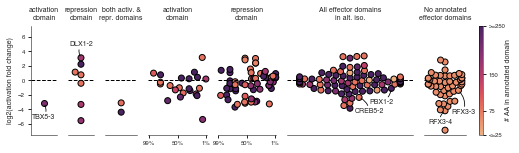

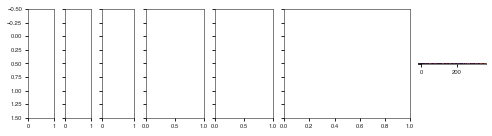

In [35]:
palette = palette_dom_length
hue = 'tot_dom_length'
color = 'color_dom_length'
t = t_dom_length

gs_kw = dict(width_ratios=[0.4, 0.4, 0.5, 0.9, 0.9, 1.95, 1])

fig, axs = plt.subplots(1, 7, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                        & (df['fraction_of_Bif_domains_removed'].isnull() | 
                           (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[0].set_title('activation\ndomain')
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tbx5_y = df.loc[(df["clone_acc_alt"] == "TBX5|3/3|08H01"), 'activation_fold_change_log2'].values[0]
for point in axs[0].collections:
    for x, y in point.get_offsets():
        if np.isclose(tbx5_y, y):
            print("found: %s, %s" % (x, y))
            axs[0].annotate("TBX5-3", xy=(x, y), xytext=(0, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[1].set_title('repression\ndomain')
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()

dlx1_y = df.loc[(df["clone_acc_alt"] == "DLX1|2/2|07E09"), 'activation_fold_change_log2'].values[0]
for point in axs[1].collections:
    for x, y in point.get_offsets():
        if np.isclose(dlx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[1].annotate("DLX1-2", xy=(x, y), xytext=(0, 10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="center", va="bottom", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
                          (df['fraction_of_RD_domains_removed'] == 1), :]
axs[2].set_title('both activ. &\nrepr. domains')
sns.swarmplot(data=tot_loss_both,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[2],
              palette=palette,
              hue=hue,
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[2].set_xticks([])
axs[2].set_xlabel('')
axs[2].get_legend().remove()


# now partial loss
axs[3].set_title('activation\ndomain')
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]
axs[3].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


axs[4].set_title('repression\ndomain')
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]

axs[4].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, color].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[4].set_xlabel('')
axs[4].set_xlim(1, 0)
axs[4].set_xticks([0.99, 0.5, 0.01])
axs[4].set_xticklabels([f'{x:.0%}' for x in axs[4].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :]
axs[5].set_title('All effector domains\nin alt. iso.')
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue=hue,
              palette=palette)
axs[5].set_xticks([])
axs[5].set_xlabel('')
axs[5].get_legend().remove()

# annotate pbx1 and rfx3
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
creb5_y = df.loc[(df["clone_acc_alt"] == "CREB5|2/3|08A12"), 'activation_fold_change_log2'].values[0]
for point in axs[5].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("PBX1-2", xy=(x, y), xytext=(-10, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(creb5_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("CREB5-2", xy=(x, y), xytext=(10, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = pd.concat([tot_loss_activ, 
                  tot_loss_repr, 
                  tot_loss_both, 
                  partial_loss_activ, 
                  partial_loss_repr, 
                  all_retained])

no_annot = df.loc[(~df.index.isin(incl.index.values)) & (pd.isnull(df["fraction_of_AD_domains_removed"])) &
                  (pd.isnull(df["fraction_of_RD_domains_removed"])) & 
                  (pd.isnull(df["fraction_of_Bif_domains_removed"]))]
axs[6].set_title('No annotated\neffector domains')
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[6],
              linewidth=1,
               edgecolor="black",
              alpha=1,
              color=sns.color_palette("flare")[0])
axs[6].set_xticks([])
axs[6].set_xlabel('')

rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[6].collections:
    for x, y in point.get_offsets():
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[6].annotate("RFX3-3", xy=(x, y), xytext=(5, -18), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[6].annotate("RFX3-4", xy=(x, y), xytext=(-5, -8), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3",
                                              color='black'), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


# add colorbar
# mirror figure
fig2, axs2 = plt.subplots(1, 7, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[6].imshow(np.stack([t, t]), cmap="flare", vmin=25, vmax=250)
cbar = fig.colorbar(map1, ax=axs[6], aspect=30, pad=0.2)
cbar.set_ticks([25, 75, 150, 250])
cbar.set_ticklabels(["<=25", "75", "150", ">=250"])
cbar.set_label("# AA in annotated domain", labelpad=0)


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed', zorder=1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../../figures/fig4/activation_vs_domain_removal_colored_by_dom_length.pdf', bbox_inches='tight')

## 6. pie chart of PPI categories

In [36]:
len(cats)

928

In [37]:
len(cats.gene_symbol_partner.unique())

928

In [38]:
cats.category.value_counts()

other        377
TF           219
signaling    214
cofactor     118
Name: category, dtype: int64

In [39]:
y2h_nonan = y2h[~pd.isnull(y2h["Y2H_result"])]
len(y2h_nonan.db_gene_symbol.unique())

500

In [40]:
ggi = y2h_nonan[["ad_gene_symbol", "db_gene_symbol"]].drop_duplicates()
ggi

,ad_gene_symbol,db_gene_symbol
0,ATF2,ATF2
4,ATF2,JDP2
39,ATF2,FOSL2
73,ATF2,MAPK9
122,CREB5,EFEMP2
...,...,...
10218,TCF12,HEXIM2
10246,DDIT3,ZBTB25
10247,DDIT3,ZC3H14
10271,TCF12,EPHB6


In [41]:
# limiting df to those that are in the y2h iso data
cats_y2h = cats[cats["gene_symbol_partner"].isin(ggi["db_gene_symbol"])]
len(cats_y2h)

500

In [42]:
cats_dupe = cats_y2h.groupby("gene_symbol_partner")["category"].agg("count").reset_index()
cats_dupe[cats_dupe["category"] > 1].head()

,gene_symbol_partner,category


gene partners are now in mutually exclusive categories

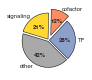

In [43]:
ys = np.array([len(cats_y2h[cats_y2h["category"] == "TF"]), len(cats_y2h[cats_y2h["category"] == "cofactor"]),
               len(cats_y2h[cats_y2h["category"] == "signaling"]),
              len(cats_y2h[cats_y2h["category"] == "other"])])
labels = ["TF", "cofactor", "signaling", "other"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[5], "darkgray"]

fig, ax = plt.subplots(figsize=(1.2, 1.2), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.0f%%', startangle=-45, 
                    explode=(0.02, 0.2, 0.05, 0.05))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")
    n.set_fontsize(6)

fig.savefig("../../figures/fig4/PPIs-gene-level-manual-categories_simplified.pdf", dpi="figure", bbox_inches="tight")

In [44]:
cofactor_partners = set(cats_y2h.loc[cats_y2h['category'] == 'cofactor', 'gene_symbol_partner'].unique())
signaling_partners = set(cats_y2h.loc[cats_y2h['category'] == 'signaling', 'gene_symbol_partner'].unique())
other_partners = set(cats_y2h.loc[cats_y2h['category'] == 'other', 'gene_symbol_partner'].unique())
tf_gene_symbols = set(load_human_tf_db()['HGNC symbol'].values)

In [45]:
cats_y2h.cofactor_type.value_counts()

unknown        42
corepressor     7
coactivator     6
both            3
Name: cofactor_type, dtype: int64

In [46]:
list(signaling_partners)[25:35]

['DNAJC27',
 'NCK2',
 'AQP1',
 'DTNB',
 'NEK8',
 'UBE2I',
 'GAS8',
 'MOAP1',
 'RECK',
 'MAPKBP1']

## 7. plot the relationship between gain/loss of PPIs and changes in activity

In [47]:
def add_restricted_ppi_columns(pairs, rows, label):
    pairs_cf = pairs[['clone_acc_ref', 'clone_acc_alt']].copy()
    _add_PPI_columns(df=pairs_cf, y2h=y2h.loc[rows, :])
    return pd.merge(pairs, 
                    pairs_cf,
                    how='left',
                    on=['clone_acc_ref', 'clone_acc_alt'],
                    suffixes=('', '_' + label))

In [48]:
pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(cofactor_partners),
                           label='cofactors'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(cofactor_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='cofactors_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(signaling_partners),
                           label='signaling'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(signaling_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='signaling_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=y2h['db_gene_symbol'].isin(tf_gene_symbols),
                           label='tfs'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(tf_gene_symbols) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='tfs_HEK'
)

pairs = add_restricted_ppi_columns(pairs, 
                           rows=(y2h['db_gene_symbol'].isin(other_partners) &
                                 y2h['db_gene_symbol'].isin(hek_expressed_genes)),
                           label='other_HEK'
)

In [49]:
def bar_activation_vs_ppi(x, y, pairs=pairs, x_label=None, y_label=None, color=None):
    """
    TODO:
        - calculate p-value properly
            - this requires permuting in some smart way
            - one question is whether the genes are the number of independent data points or the isoforms are
            - I think the answer is the isoforms are
    
    """
    df = pairs.copy()
    if x_label is None:
        x_label = x
    if y_label is None:
        y_label = y
    if color is None:
        color = sns.color_palette("Set2")[1]
    fig, ax = plt.subplots(1, 1, figsize=(1.15, 1.5))

    def bin_delta_ppi(delta_ppi):
        if pd.isnull(delta_ppi):
            return np.nan
        if delta_ppi < 0:
            return 'change'
        elif delta_ppi > 0:
            return 'change'
        elif delta_ppi == 0:
            return 'equal'
        else:
            raise ValueError(delta_ppi)


    df[x + '_binned'] = df[x].apply(bin_delta_ppi)
    sns.stripplot(data=df,
                  x=x + '_binned',
                  y=y,
                  order=['equal', 'change'],
                  alpha=0.75,
                  color=color,
                  linewidth=1,
                  edgecolor="black",
                  ax=ax)
    if False:
        sns.pointplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['equal', 'change'],
                    alpha=0.5,
                    color='black',
                    ax=ax)
    if True:
        sns.boxplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['equal', 'change'],
                    fliersize=0,
                    color=color,
                    ax=ax)
        mimic_r_boxplot(ax)
    else:
        sns.violinplot(data=df,
                    x=x + '_binned',
                    y=y,
                    order=['equal', 'change'],
                    color='lightgrey',
                    ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    with_data = (df[x].notnull() & df[y].notnull())
    n_pair = with_data.sum()
    n_iso = len(set(df.loc[with_data, ['clone_acc_ref', 'clone_acc_alt']].values.flatten()))
    n_gene = df.loc[with_data, 'gene_symbol'].nunique()
    
    dist_a = df[df[x + '_binned'] == 'equal'][y].values
    dist_b = df[df[x + '_binned'] == 'change'][y].values
    u, p = stats.mannwhitneyu(dist_a, dist_b, alternative="less")
    plotting.annotate_pval(ax, 0.2, 0.8, 2.4, 0, 2.4, p, 7)
    
    ax.text(s=f'{n_pair:d} pairs\n{n_iso:d} isoforms\n{n_gene:d} genes\np = {p:.2f}',
            x=1.03,
            y=0.95,
            ha='left',
            va='top',
            transform=ax.transAxes)
    #ax.set_ylim(-4, 4) # NOTE cuts outlier TODO add broken axis

    for pos in ['top', 'bottom', 'right']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../../figures/fig4/{x}-vs-{y}_scatter.pdf',
                bbox_inches='tight')

In [50]:
pairs['activation_abs_fold_change'] = pairs['activation_fold_change_log2'].abs()

In [51]:
# limit to pairs w signal in m1h
df = pairs.copy()
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
len(df)

254

../plotting.py:564: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


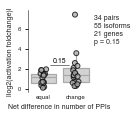

In [52]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_other_HEK',
    y='activation_abs_fold_change',
    x_label='Net difference in number of PPIs',
    y_label='|log2(activation foldchange)|',
    color="darkgrey")

../plotting.py:564: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


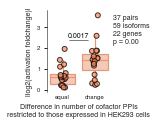

In [53]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_cofactors_HEK',
    y='activation_abs_fold_change',
    x_label='Difference in number of cofactor PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='|log2(activation foldchange)|',
    color=sns.color_palette("Set2")[1])

../plotting.py:564: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


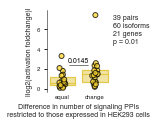

In [54]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_signaling_HEK',
    y='activation_abs_fold_change',
    x_label='Difference in number of signaling PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='|log2(activation foldchange)|',
    color=sns.color_palette("Set2")[5])

../plotting.py:564: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


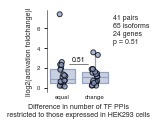

In [55]:
bar_activation_vs_ppi(
    pairs=df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :],
    x='PPI_delta_n_tfs_HEK',
    y='activation_abs_fold_change',
    x_label='Difference in number of TF PPIs\nrestricted to those expressed in HEK293 cells',
    y_label='|log2(activation foldchange)|',
    color=sns.color_palette("Set2")[2])

In [56]:
df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :].PPI_delta_n_tfs_HEK.value_counts()

 0.0    20
-1.0     9
-2.0     4
-5.0     2
 1.0     2
 2.0     1
-3.0     1
-4.0     1
 3.0     1
Name: PPI_delta_n_tfs_HEK, dtype: int64

In [57]:
df.loc[df['at_least_one_isoform_in_gene_abs_activation_gte_2fold'] == True, :].PPI_delta_n_cofactors_HEK.value_counts()

 0.0    18
-3.0     6
 1.0     5
-1.0     5
-2.0     2
 4.0     1
Name: PPI_delta_n_cofactors_HEK, dtype: int64

## 7. dimerizing TFs: plot conservation of interactions across isoforms

In [55]:
ppi = load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=True)
ppi.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [56]:
n_iso_per_ppi = (ppi.groupby(['ad_gene_symbol', 'db_gene_symbol']))['ad_clone_acc'].agg("count").reset_index()
n_true_iso_per_ppi = (ppi[ppi['Y2H_result'] == True].groupby(['ad_gene_symbol', 
                                                              'db_gene_symbol']))['ad_clone_acc'].agg("count").reset_index()
n_iso_per_ppi = n_iso_per_ppi.merge(n_true_iso_per_ppi, on=['ad_gene_symbol', 'db_gene_symbol'], how='left')
n_iso_per_ppi['f_iso_positive'] = n_iso_per_ppi['ad_clone_acc_y']/n_iso_per_ppi['ad_clone_acc_x']
n_iso_per_ppi = n_iso_per_ppi[['ad_gene_symbol', 'db_gene_symbol', 'f_iso_positive']]
n_iso_per_ppi

,ad_gene_symbol,db_gene_symbol,f_iso_positive
0,ARNT2,EIF3E,1.0
1,ARNT2,LMO3,1.0
2,ARNT2,NABP1,1.0
3,ARNT2,NRBP1,1.0
4,ARNT2,SCNM1,0.5
...,...,...,...
781,ZSCAN18,ZNF792,0.5
782,ZSCAN18,ZSCAN22,0.5
783,ZSCAN9,SCAND1,0.5
784,ZSCAN9,SRPK2,0.5


In [57]:
n_iso_per_ppi = pd.merge(n_iso_per_ppi,
                         ppi.groupby(['ad_gene_symbol',
                                      'db_gene_symbol'])
                                ['Y2H_result']
                                .apply(lambda x: x.notnull().sum())
                                .rename('n_iso_successfully_tested')
                                .reset_index(),
                            how='left',
                            on=['ad_gene_symbol', 'db_gene_symbol'],
                            )
if n_iso_per_ppi['n_iso_successfully_tested'].isnull().any():
    raise UserWarning('unexpected missing values')
n_iso_per_ppi = n_iso_per_ppi.loc[n_iso_per_ppi['n_iso_successfully_tested'] >= 2, :]

In [58]:
tf_fam = load_tf_families()

In [59]:
n_iso_per_ppi['db_is_tf'] = n_iso_per_ppi['db_gene_symbol'].isin(tf_fam)
n_iso_per_ppi['ad_tf_family'] = n_iso_per_ppi['ad_gene_symbol'].map(tf_fam)
n_iso_per_ppi['db_tf_family'] = n_iso_per_ppi['db_gene_symbol'].map(tf_fam)

In [60]:
def tf_tf_dimer_ppi_catagories(row):
    is_dimer_ad = row['ad_tf_family'] in DIMERIZING_TF_FAMILIES
    if pd.isnull(row['db_tf_family']):
        if is_dimer_ad:
            return 'Dimerizing TF / other'
        else:
            return 'Non-dimerizing TF / other'
    else:  # TF-TF PPI
        if is_dimer_ad:
            if row['db_tf_family'] == row['ad_tf_family']:
                return 'Dimerzing TF-TF PPI'
            else:
                return 'Outside family TF-TF PPI'
        else:
            if row['db_tf_family'] == row['ad_tf_family']:
                return 'Non-dimer TF-TF PPI'
            else:
                return 'Outside family TF-TF PPI'


n_iso_per_ppi['dimer_cat'] = n_iso_per_ppi.apply(tf_tf_dimer_ppi_catagories,
                                                 axis=1)

n_iso_per_ppi.head()

,ad_gene_symbol,db_gene_symbol,f_iso_positive,n_iso_successfully_tested,db_is_tf,ad_tf_family,db_tf_family,dimer_cat
0,ARNT2,EIF3E,1.0,2,False,bHLH,NaN,Dimerizing TF / other
1,ARNT2,LMO3,1.0,2,False,bHLH,NaN,Dimerizing TF / other
2,ARNT2,NABP1,1.0,2,False,bHLH,NaN,Dimerizing TF / other
3,ARNT2,NRBP1,1.0,2,False,bHLH,NaN,Dimerizing TF / other
4,ARNT2,SCNM1,0.5,2,False,bHLH,NaN,Dimerizing TF / other


In [61]:
# permutation test
cats = [
 'Dimerzing TF-TF PPI',
 'Dimerizing TF / other',
 'Outside family TF-TF PPI',
 'Non-dimer TF-TF PPI',
 'Non-dimerizing TF / other',
 ]

rnd_vals = {}
obs_val = {}
for cat in cats[1:]:
    rnd_vals[cat] = []
    obs_val[cat] = (n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cats[0], 
                                            'f_iso_positive'].mean() - 
                n_iso_per_ppi.loc[n_iso_per_ppi['dimer_cat'] == cat, 
                                            'f_iso_positive'].mean())
for _i in range(10000):
    rand_cats = n_iso_per_ppi['dimer_cat'].sample(frac=1).reset_index(drop=True)  # equivalent to shuffle
    for cat in cats[1:]:
        rnd_vals[cat].append(n_iso_per_ppi.loc[rand_cats == cats[0], 
                                            'f_iso_positive'].mean() - 
                            n_iso_per_ppi.loc[rand_cats == cat, 
                                            'f_iso_positive'].mean())

pvals = {}
for cat in cats[1:]:
    pvals[cat] = sum(v >= obs_val[cat] for v in rnd_vals[cat]) / len(rnd_vals[cat])
pvals

{'Dimerizing TF / other': 0.0001,
 'Outside family TF-TF PPI': 0.0,
 'Non-dimer TF-TF PPI': 0.0,
 'Non-dimerizing TF / other': 0.0}

In [62]:
def permutation_test(sample1, sample2, num_permutations=1000, seed=None, alternative='two-sided'):
    """
    Conduct a permutation test on two samples.

    :param sample1: First sample (array-like)
    :param sample2: Second sample (array-like)
    :param num_permutations: Number of permutations to perform (int)
    :param seed: Seed for random number generator (int)
    :param alternative: Defines the alternative hypothesis. 
                        'two-sided': the distributions are not equal,
                        'less': the distribution of sample1 is less than the distribution of sample2,
                        'greater': the distribution of sample1 is greater than the distribution of sample2
    :return: p-value (float)
    """

    # Ensure reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Combine the samples
    combined = np.concatenate([sample1, sample2])

    # Calculate the observed test statistic
    observed_stat = np.mean(sample1) - np.mean(sample2)

    # Perform the permutations
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_sample_1 = combined[:len(sample1)]
        new_sample_2 = combined[len(sample1):]

        # Calculate the new test statistic
        new_stat = np.mean(new_sample_1) - np.mean(new_sample_2)

        # Check if the new test statistic is at least as extreme as the original
        if alternative == 'two-sided':
            count += abs(new_stat) >= abs(observed_stat)
        elif alternative == 'less':
            count += new_stat <= observed_stat
        elif alternative == 'greater':
            count += new_stat >= observed_stat
        else:
            raise ValueError("alternative must be 'two-sided', 'less', or 'greater'")

    # Calculate the p-value
    p_value = (count + 1) / (num_permutations + 1)

    return p_value

In [63]:
def bootstrap_99_ci(series, n_bootstraps=1000):
    """
    Calculate the 95% confidence interval using bootstrapping.
    
    :param series: Data points as a pandas Series.
    :param n_bootstraps: Number of bootstrap iterations.
    :return: A tuple containing the lower and upper confidence interval bounds.
    """
    bootstrapped_means = []
    for _ in range(n_bootstraps):
        sample = series.sample(n=len(series), replace=True)  # Sampling with replacement
        sample_mean = sample.mean()
        bootstrapped_means.append(sample_mean)

    lower, upper = np.percentile(bootstrapped_means, [0.5, 99.5])  # 99% confidence interval
    return lower, upper

pair: ('Dimerzing TF-TF PPI', 'Dimerizing TF / other') | p-val: 9.999000099990002e-05
pair: ('Dimerzing TF-TF PPI', 'Outside family TF-TF PPI') | p-val: 9.999000099990002e-05
pair: ('Dimerzing TF-TF PPI', 'Non-dimer TF-TF PPI') | p-val: 9.999000099990002e-05
pair: ('Dimerzing TF-TF PPI', 'Non-dimerizing TF / other') | p-val: 9.999000099990002e-05


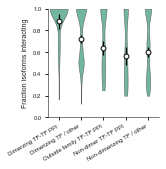

In [64]:
# n for each bar
# axis labels etc.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=2)
violinplot_reflected(data=n_iso_per_ppi,
              x='dimer_cat',
              y='f_iso_positive',
              inner=None,
              cut=0,
              color=sns.color_palette("Set2")[0],
              order=cats,
              alpha=0.75,
              linewidth=0.5,
              ax=ax)

# add markers for mean + 95% ci [avoids using pointplot which is not that customizable, aesthetically]
means = n_iso_per_ppi.groupby("dimer_cat")["f_iso_positive"].agg("mean").reset_index()
cis = n_iso_per_ppi.groupby("dimer_cat")["f_iso_positive"].apply(bootstrap_99_ci).reset_index()
cis[['lower', 'upper']] = pd.DataFrame(cis['f_iso_positive'].tolist(), index=cis.index)

# reorder so they're in the same order
cis.set_index("dimer_cat", inplace=True)
means_tmp = means.set_index("dimer_cat")
cis = cis.loc[cats, :]
means_tmp = means_tmp.loc[cats, :]

# add points
sns.swarmplot(data=means, x='dimer_cat', y='f_iso_positive', order=cats, ax=ax,
              color="white", edgecolor="black", linewidth=0.25, size=4)
ax.errorbar(x=range(len(cats)), y=means_tmp["f_iso_positive"], 
            yerr=[means_tmp["f_iso_positive"] - cis["lower"], cis["upper"] - means_tmp["f_iso_positive"]], 
            fmt='o', color="black")

# now add p-vals
pairs_to_test = [(cats[0], cat) for cat in cats[1:]]
for i, pair in enumerate(pairs_to_test):
    x = n_iso_per_ppi[n_iso_per_ppi["dimer_cat"] == pair[0]]["f_iso_positive"].values
    y = n_iso_per_ppi[n_iso_per_ppi["dimer_cat"] == pair[1]]["f_iso_positive"].values
    p = permutation_test(x, y, num_permutations=10000, alternative="two-sided")
    #plotting.annotate_pval(ax, 0.2, (i+1)-0.2, ty, 0, ty, p, 7)
    # pvals look ugly - just print
    print("pair: %s | p-val: %s" % (pair, p))

ax.set_ylabel('Fraction isoforms interacting')
ax.set_xlabel('')

ax.set_xticklabels(cats, rotation=30, ha='right', va='top')

ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig('../../figures/fig4/n_iso_ppi_by_dimer_cat.pdf',
            bbox_inches='tight')

## 8. dimerizing TFs: plot M1H change

In [65]:
len(pairs)

446

In [66]:
len(pairs[~pd.isnull(pairs['activation_abs_fold_change'])])

327

In [67]:
# limit to pairs w signal in m1h
df = pairs.copy()
df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]
len(df)

254

In [68]:
df[~pd.isnull(df['activation_abs_fold_change'])].groupby("is_dimerizing_TF_family")["activation_abs_fold_change"].agg("mean")

is_dimerizing_TF_family
False    1.248606
True     1.543294
Name: activation_abs_fold_change, dtype: float64

In [69]:
df[~pd.isnull(df['activation_abs_fold_change'])].groupby("is_dimerizing_TF_family")["activation_abs_fold_change"].agg("median")

is_dimerizing_TF_family
False    0.839813
True     1.077391
Name: activation_abs_fold_change, dtype: float64

In [70]:
df_nonan = df[~pd.isnull(df["activation_abs_fold_change"])]
x = df_nonan[df_nonan["is_dimerizing_TF_family"] == True]["activation_abs_fold_change"].values
y = df_nonan[df_nonan["is_dimerizing_TF_family"] == False]["activation_abs_fold_change"].values

permutation_test(x, y, num_permutations=10000, alternative="two-sided")

0.07949205079492051

../plotting.py:564: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


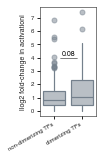

In [71]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1, h=2)

ax = sns.boxplot(data=df, x="is_dimerizing_TF_family", y="activation_abs_fold_change", 
                 flierprops={"marker": "o"}, color="slategrey")
mimic_r_boxplot(ax)

# p-value
df_nonan = df[~pd.isnull(df["activation_abs_fold_change"])]
x = df_nonan[df_nonan["is_dimerizing_TF_family"] == True]["activation_abs_fold_change"].values
y = df_nonan[df_nonan["is_dimerizing_TF_family"] == False]["activation_abs_fold_change"].values

pval = permutation_test(x, y, num_permutations=10000, alternative="two-sided")
plotting.annotate_pval(ax, 0.2, 0.8, 4, 0, 4, pval, 7)

ax.set_xlabel("")
ax.set_xticklabels(["non-dimerizing TFs", "dimerizing TFs"], rotation=30, ha="right", va="top")
ax.set_ylabel("|log2 fold-change in activation|")

fig.savefig("../../figures/fig4/M1H_activ_v_dimerization.pdf", dpi="figure", bbox_inches="tight")

## 9. dimerizing TFs: retained interactions heatmap

In [72]:
# TF-TF binding
tftf = ppi.loc[ppi['Y2H_result'] == True, ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().copy()
tftf['ad_dbd'] = tftf['ad_gene_symbol'].map(tf_fam)
tftf['db_dbd'] = tftf['db_gene_symbol'].map(tf_fam)
tftf = tftf.dropna()
tftf.head()

,ad_gene_symbol,db_gene_symbol,ad_dbd,db_dbd
0,ATF2,ATF2,bZIP,bZIP
4,ATF2,JDP2,bZIP,bZIP
39,ATF2,FOSL2,bZIP,bZIP
123,CREB5,FOSL2,bZIP,bZIP
155,GLI1,PIN1,C2H2 ZF,MBD


In [73]:
# TF-TF rewiring
tftf = pd.merge(tftf, 
        (ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x == False).sum()) / 
 ppi.groupby(['ad_gene_symbol', 'db_gene_symbol'])['Y2H_result'].apply(lambda x: (x.notnull().sum()))).reset_index(),
        how='left',
        on=['ad_gene_symbol', 'db_gene_symbol'])

In [74]:
tftf.loc[tftf['db_dbd'] == 'bHLH', 'ad_gene_symbol'].value_counts()

TCF4      12
TCF12     10
ARNTL2     2
MEOX1      2
ESRRA      2
IKZF2      1
FOS        1
ESRRG      1
ZBTB44     1
ZNF438     1
ARNT2      1
Name: ad_gene_symbol, dtype: int64

In [75]:
DIMERIZING_TF_FAMILIES

{'AP-2',
 'ARID/BRIGHT',
 'BED ZF',
 'CENPB',
 'E2F',
 'EBF1',
 'GCM',
 'Grainyhead',
 'HSF',
 'IRF',
 'MADF',
 'MADS box',
 'Myb/SANT',
 'Nuclear receptor',
 'RFX',
 'Rel',
 'SAND',
 'SMAD',
 'STAT',
 'bHLH',
 'bZIP',
 'p53'}

In [76]:
fams = tf_fam.value_counts().index
fams = list(filter(lambda x: x in tftf['ad_dbd'].unique() or x in tftf['db_dbd'].unique(), fams))
len(fams)

30

In [77]:
num_pairs = [((tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y)).sum() for x in fams for y in fams]
num_pairs = np.reshape(num_pairs, (-1, len(fams)))
num_pairs = pd.DataFrame(num_pairs, index=fams, columns=fams)
num_pairs.head()

,C2H2 ZF,Homeodomain,bHLH,Unknown,bZIP,Forkhead,Nuclear receptor,HMG/Sox,Ets,T-box,...,C2H2 ZF; AT hook,C2H2 ZF; Homeodomain,CCCH ZF,TBP,p53,CSL,Pipsqueak,C2H2 ZF; BED ZF,TCR/CxC,CBF/NF-Y
C2H2 ZF,52,7,3,1,0,0,2,2,0,1,...,1,0,2,0,0,0,0,1,1,0
Homeodomain,6,14,2,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
bHLH,5,6,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Unknown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bZIP,1,0,1,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
tftf.sample(5)

,ad_gene_symbol,db_gene_symbol,ad_dbd,db_dbd,Y2H_result
21,NFYA,NFYC,CBF/NF-Y,Unknown,0.0
56,PPARG,RXRB,Nuclear receptor,Nuclear receptor,0.0
46,ZBTB44,ZNF417,C2H2 ZF,C2H2 ZF,0.8
69,SOX6,SOX5,HMG/Sox,HMG/Sox,0.0
7,FOXP2,VEZF1,Forkhead,C2H2 ZF,0.5


In [79]:
tftf[(tftf["ad_dbd"] == "bZIP") & (tftf["db_dbd"] == "bZIP")]

,ad_gene_symbol,db_gene_symbol,ad_dbd,db_dbd,Y2H_result
0,ATF2,ATF2,bZIP,bZIP,0.500000
1,ATF2,JDP2,bZIP,bZIP,0.333333
2,ATF2,FOSL2,bZIP,bZIP,0.666667
3,CREB5,FOSL2,bZIP,bZIP,0.000000
10,NFE2L2,MAFG,bZIP,bZIP,0.000000
11,NFE2L2,MAFK,bZIP,bZIP,0.000000
38,FOS,ATF2,bZIP,bZIP,0.000000
195,FOSB,ATF2,bZIP,bZIP,0.000000
222,DDIT3,CREBL2,bZIP,bZIP,0.500000
223,DDIT3,FOSL2,bZIP,bZIP,0.000000


In [80]:
rewiring = [tftf.loc[(tftf['ad_dbd'] == x) & (tftf['db_dbd'] == y), 'Y2H_result'].mean() for x in fams for y in fams]
rewiring = np.reshape(rewiring, (-1, len(fams)))
rewiring = pd.DataFrame(rewiring, index=fams, columns=fams)
rewiring.head()

,C2H2 ZF,Homeodomain,bHLH,Unknown,bZIP,Forkhead,Nuclear receptor,HMG/Sox,Ets,T-box,...,C2H2 ZF; AT hook,C2H2 ZF; Homeodomain,CCCH ZF,TBP,p53,CSL,Pipsqueak,C2H2 ZF; BED ZF,TCR/CxC,CBF/NF-Y
C2H2 ZF,0.527564,0.333333,0.588889,0.666667,NaN,NaN,0.750000,0.625,NaN,0.75,...,0.75,NaN,0.583333,NaN,NaN,NaN,NaN,0.0,0.333333,NaN
Homeodomain,0.500000,0.190476,0.666667,0.500000,NaN,NaN,0.666667,NaN,0.333333,NaN,...,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
bHLH,0.250000,0.300595,0.023333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bZIP,0.000000,NaN,0.000000,NaN,0.153846,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# limit to fams w 10 DB
num_pairs_sum = num_pairs.sum(axis=0)
filt_fams = num_pairs_sum[num_pairs_sum >= 3]
filt_fams

C2H2 ZF             75
Homeodomain         37
bHLH                34
Unknown             10
bZIP                14
Nuclear receptor    10
HMG/Sox              4
Ets                  3
THAP finger          3
E2F                  3
SMAD                 5
MBD                 12
dtype: int64

In [82]:
rewiring_filt = rewiring.loc[list(filt_fams.index), list(filt_fams.index)]
rewiring_filt

,C2H2 ZF,Homeodomain,bHLH,Unknown,bZIP,Nuclear receptor,HMG/Sox,Ets,THAP finger,E2F,SMAD,MBD
C2H2 ZF,0.527564,0.333333,0.588889,0.666667,NaN,0.750000,0.625,NaN,0.708333,NaN,0.666667,0.000000
Homeodomain,0.500000,0.190476,0.666667,0.500000,NaN,0.666667,NaN,0.333333,NaN,NaN,0.666667,0.611111
bHLH,0.250000,0.300595,0.023333,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,0.250000,0.000000
Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bZIP,0.000000,NaN,0.000000,NaN,0.153846,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
Nuclear receptor,0.250000,0.250000,0.000000,0.200000,NaN,0.071429,NaN,NaN,NaN,NaN,NaN,NaN
HMG/Sox,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN
Ets,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
THAP finger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E2F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166667,NaN,NaN


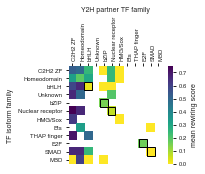

In [83]:
fig = plt.figure(figsize=(2.1, 1.8))

# transposing so the orientation matches the y2h figures
g = sns.heatmap(rewiring_filt.T, cmap="viridis_r", cbar_kws={"label": "mean rewiring score"})

# highlight the squares corresponding to dimerizing pairs
for i, fam in enumerate(list(filt_fams.index)):
    if fam in DIMERIZING_TF_FAMILIES:
        g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1))
        
g.set_ylabel("TF isoform family")
g.set_xlabel("Y2H partner TF family")
g.xaxis.tick_top()
g.xaxis.set_label_position('top')
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="left", va="bottom")
fig.savefig("../../figures/fig4/Dimerizing_PPI_heatmap.small.pdf", dpi="figure", bbox_inches="tight")

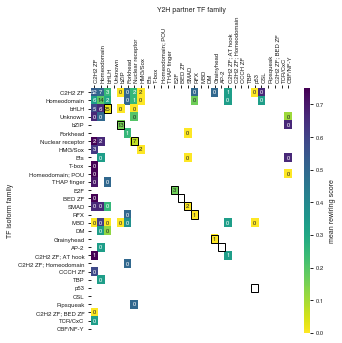

In [84]:
fig = plt.figure(figsize=(4.5, 4.5))
g = sns.heatmap(rewiring.T, cmap="viridis_r", cbar_kws={"label": "mean rewiring score", "aspect": 40},
                annot=num_pairs, annot_kws={"fontsize": 6})

# highlight the squares corresponding to dimerizing pairs
for i, fam in enumerate(list(rewiring.index)):
    if fam in DIMERIZING_TF_FAMILIES:
        g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=1))
        
g.set_ylabel("TF isoform family")
g.set_xlabel("Y2H partner TF family")
g.xaxis.tick_top()
g.xaxis.set_label_position('top')
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="left", va="bottom")
fig.savefig("../../figures/fig4/Dimerizing_PPI_heatmap.all.pdf", dpi="figure", bbox_inches="tight")

## 10. isoform example vignettes

In [85]:
# reload data since we edited dfs above
y2h = load_isoform_and_paralog_y2h_data()
y1h = load_y1h_pdi_data(add_missing_data=True)
m1h = load_m1h_activation_data(add_missing_data=True)
isoforms = load_valid_isoform_clones()
y2h = y2h.loc[y2h['ad_clone_acc'].isin(isoforms['clone_acc']).values, :]
y1h = y1h.loc[y1h['clone_acc'].isin(isoforms['clone_acc']).values, :]
m1h = m1h.loc[m1h['clone_acc'].isin(isoforms['clone_acc'].values), :]

tfs = load_annotated_TFiso1_collection()

reading from cache


### RFX3

In [86]:
gene_name = "RFX3"

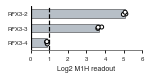

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.8))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(0, 6))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

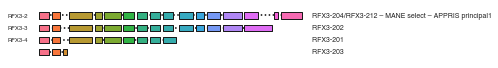

In [88]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

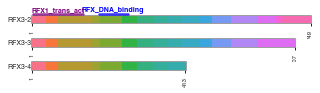

In [89]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

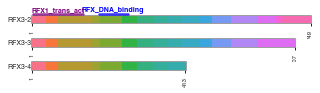

In [90]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

### PBX1

In [127]:
gene_name = "PBX1"

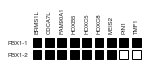

In [128]:
tf = tfs[gene_name]
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
plt.savefig('../../figures/fig4/{}_y2h-profile.pdf'.format(gene_name), bbox_inches='tight')

In [59]:
cats_y2h[cats_y2h["gene_symbol_partner"].isin(["MAPK9", "EFEMP2"])]

,gene_symbol_partner,category,cofactor_type
2,EFEMP2,other,NaN
5,MAPK9,signaling,NaN


In [136]:
pairs[pairs["gene_symbol"] == "PBX1"]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,n_positive_PPI_ref_other_HEK,n_positive_PPI_alt_other_HEK,n_PPI_successfully_tested_in_ref_and_alt_other_HEK,n_positive_PPI_ref_filtered_other_HEK,n_positive_PPI_alt_filtered_other_HEK,n_shared_PPI_other_HEK,n_PPI_diff_other_HEK,PPI_delta_n_other_HEK,PPI_jaccard_other_HEK,activation_abs_fold_change
20,PBX1,ENSG00000185630,Homeodomain,False,PBX1|1/2|02A05,PBX1|2/2|02C05,ENST00000420696,ENST00000367897,False,False,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.099522


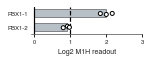

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.5))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-0.1, 3))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

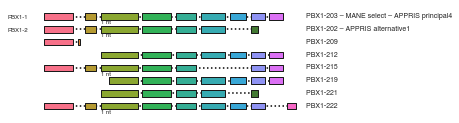

In [94]:
fig, ax = plt.subplots(figsize=(5, 2))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

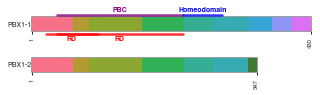

In [95]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

### CREB5

In [96]:
gene_name = "CREB5"

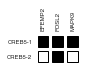

In [97]:
tf = tfs[gene_name]
fig, ax = plt.subplots(1, 1, figsize=(0.8, 0.8))
y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
plt.savefig('../../figures/fig4/{}_y2h-profile.pdf'.format(gene_name), bbox_inches='tight')

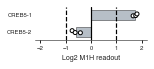

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-2.2, 2.2))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

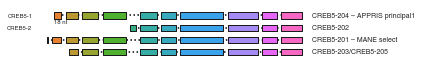

In [99]:
fig, ax = plt.subplots(figsize=(5, 1))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

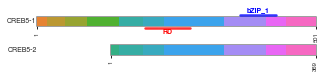

In [100]:
fig, ax = plt.subplots(figsize=(5, 0.7))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

### DLX1

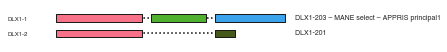

In [101]:
gene_name = "DLX1"
fig, ax = plt.subplots(figsize=(5, 0.7))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

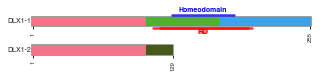

In [102]:
fig, ax = plt.subplots(figsize=(5, 0.7))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

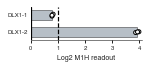

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(0, 4.1))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

### ATF2

In [104]:
gene_name = "ATF2"

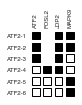

In [105]:
tf = tfs[gene_name]
fig, ax = plt.subplots(1, 1, figsize=(1.25, 1.25))
y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
plt.savefig('../../figures/fig4/{}_y2h-profile.pdf'.format(gene_name), bbox_inches='tight')

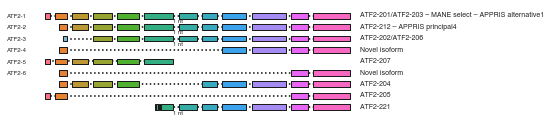

In [106]:
fig, ax = plt.subplots(figsize=(6, 2))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

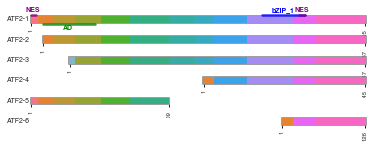

In [107]:
fig, ax = plt.subplots(figsize=(6, 2))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

### TBX5

In [108]:
gene_name = "TBX5"

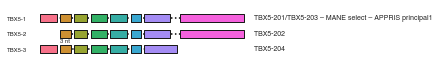

In [110]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

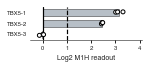

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(-0.5, 4.1))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

### TGIF1

In [114]:
gene_name = "TGIF1"

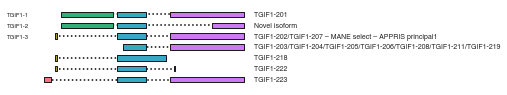

In [117]:
fig, ax = plt.subplots(figsize=(4, 1.5))

tfs[gene_name].exon_diagram(ax=ax)
fig.savefig("../../figures/fig4/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

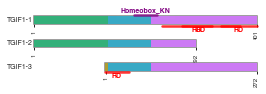

In [118]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig4/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

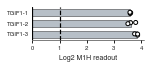

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(2, 0.6))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, xlim=(0, 4.1))
plt.savefig('../../figures/fig4/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')